# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [3]:
#импорт библиотек
import pandas_profiling 

import pandas as pd
import matplotlib.pyplot as plt # графики
import seaborn as sns #графики
import numpy as np
from sklearn.model_selection import train_test_split #деление выборок
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler #масштабирование
from sklearn.linear_model import LinearRegression # модель линейная регрессия
from sklearn.metrics import mean_squared_error, r2_score # mse, r2


In [4]:
# чтение файла
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_0 = pd.read_csv('geo_data_0.csv')
    df_1 = pd.read_csv('geo_data_1.csv')
    df_2 = pd.read_csv('geo_data_2.csv')
    


In [5]:
df_list = {'Region 0': df_0,
           'Region 1': df_1,
           'Region 2': df_2,}


#просмотр 5 пять строк каждой таблицы
for df in df_list:
    print('\033[1m' + df + '\033[0m')
    display(df_list[df].head())

Region 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Region 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Region 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
 - product — объём запасов в скважине (тыс. баррелей)

In [6]:
#просмотр общей информации
for df in df_list:
    print('\033[1m' + df + '\033[0m')
    display(df_list[df].info())

Region 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Region 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Region 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [7]:
#проверка пропусков
print('\033[1m' + '\nПроверка пропусков: ' + '\033[0m')
print()
for df in df_list:
    print('\033[1m' + df + '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(df_list[df].isnull().sum().sum()))
    


Проверка пропусков: 

Region 0
Количество пропусков: 0
Region 1
Количество пропусков: 0
Region 2
Количество пропусков: 0


In [8]:
#проверка на дубликаты
print('\033[1m' + '\nПроверка дубликатов: ' + '\033[0m')
print()
for df in df_list:
    print('\033[1m' + df + '\033[0m')
    print(df_list[df].duplicated().sum())


Проверка дубликатов: 

Region 0
0
Region 1
0
Region 2
0


In [9]:
print(df_0.columns.to_list())
print(df_1.columns.to_list())
print(df_2.columns.to_list())

['id', 'f0', 'f1', 'f2', 'product']
['id', 'f0', 'f1', 'f2', 'product']
['id', 'f0', 'f1', 'f2', 'product']


In [10]:
#удаление столбца id(не важный параметр для анализа,и для дальнейшей работы(логис. регрессия не работает со строковыми данными)
df_0 = df_0.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)
#проверка
print(df_0.columns.to_list())
print(df_1.columns.to_list())
print(df_2.columns.to_list())

['f0', 'f1', 'f2', 'product']
['f0', 'f1', 'f2', 'product']
['f0', 'f1', 'f2', 'product']


In [11]:
#описание  данных 
for df in df_list:
    print('\033[1m' + df + '\033[0m')
    display(df_list[df].describe().round(2).T)


Region 0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.50,0.87,-1.41,-0.07,0.50,1.07,2.36
f1,100000.0,0.25,0.50,-0.85,-0.20,0.25,0.70,1.34
f2,100000.0,2.50,3.25,-12.09,0.29,2.52,4.72,16.00
product,100000.0,92.50,44.29,0.00,56.50,91.85,128.56,185.36


Region 1


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.14,8.97,-31.61,-6.30,1.15,8.62,29.42
f1,100000.0,-4.80,5.12,-26.36,-8.27,-4.81,-1.33,18.73
f2,100000.0,2.49,1.70,-0.02,1.00,2.01,4.00,5.02
product,100000.0,68.83,45.94,0.00,26.95,57.09,107.81,137.95


Region 2


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.0,1.73,-8.76,-1.16,0.01,1.16,7.24
f1,100000.0,-0.0,1.73,-7.08,-1.17,-0.01,1.16,7.84
f2,100000.0,2.5,3.47,-11.97,0.13,2.48,4.86,16.74
product,100000.0,95.0,44.75,0.00,59.45,94.93,130.60,190.03


In [12]:
# количество строк со значением 0 в столбце 'product'
len(df_0[df_0['product'] == 0])

for df in df_list:
    print('\033[1m' + df + '\033[0m')
    print(len(df_list[df][df_list[df]['product'] == 0]))

Region 0
1
Region 1
8235
Region 2
1


In [13]:
def plot_hist(data, col_column):
    '''
    Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(6, 8))
    f.tight_layout()
    f.set_figheight(10)
    f.set_figwidth(8)
    plt.rcParams.update({'font.size': 10})
    
    for i, col in enumerate(col_column):         
        sns.histplot(data[col], kde=True, bins=24, ax = ax[i, 0])                    
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количественных данных", fontsize=15, y=1.01)
    plt.show()
    

In [33]:
pandas_profiling.ProfileReport(df_0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/olgafomina/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/olgafomina/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/olgafomina/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

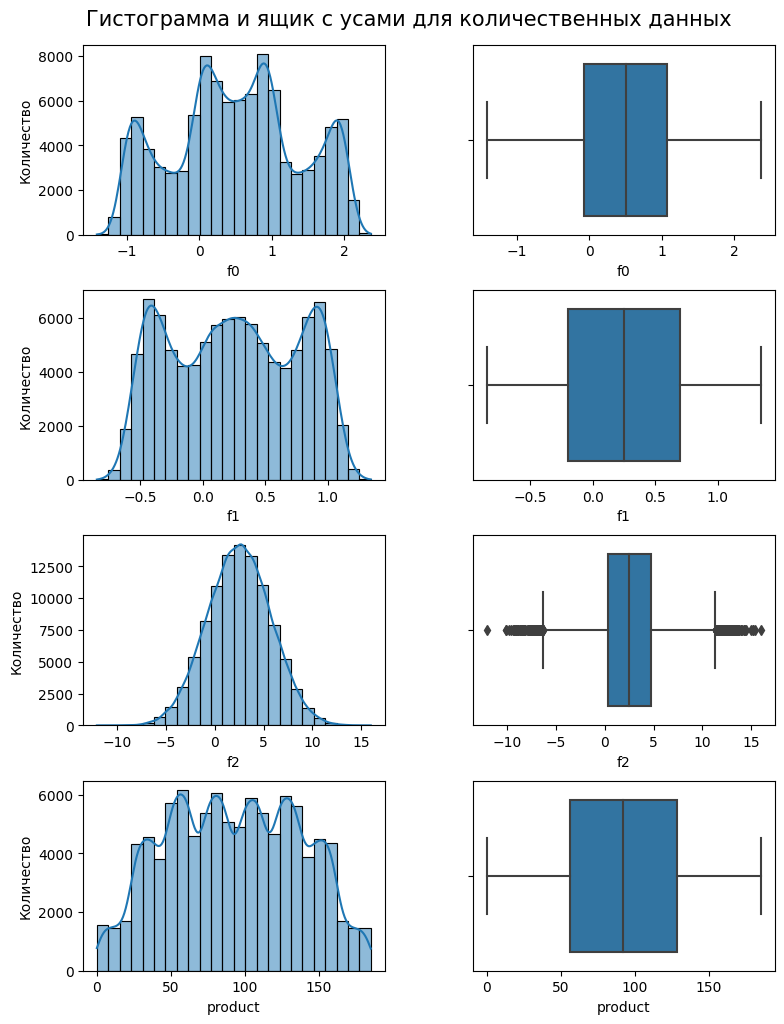

In [16]:
# графическое представление данных из таблицы df_0
plot_hist(df_0,df_0.columns);

/Users/olgafomina/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/olgafomina/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/olgafomina/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

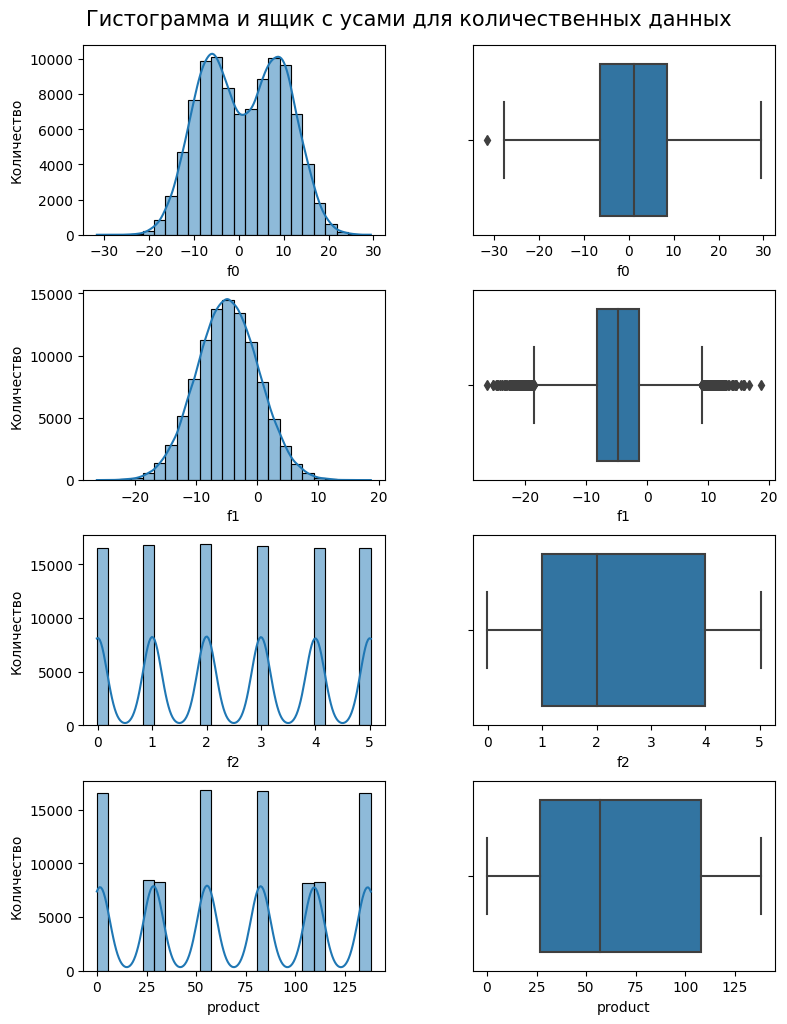

In [14]:
# графическое представление данных из таблицы df_1
plot_hist(df_1,df_1.columns)

/Users/olgafomina/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/olgafomina/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/olgafomina/opt/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

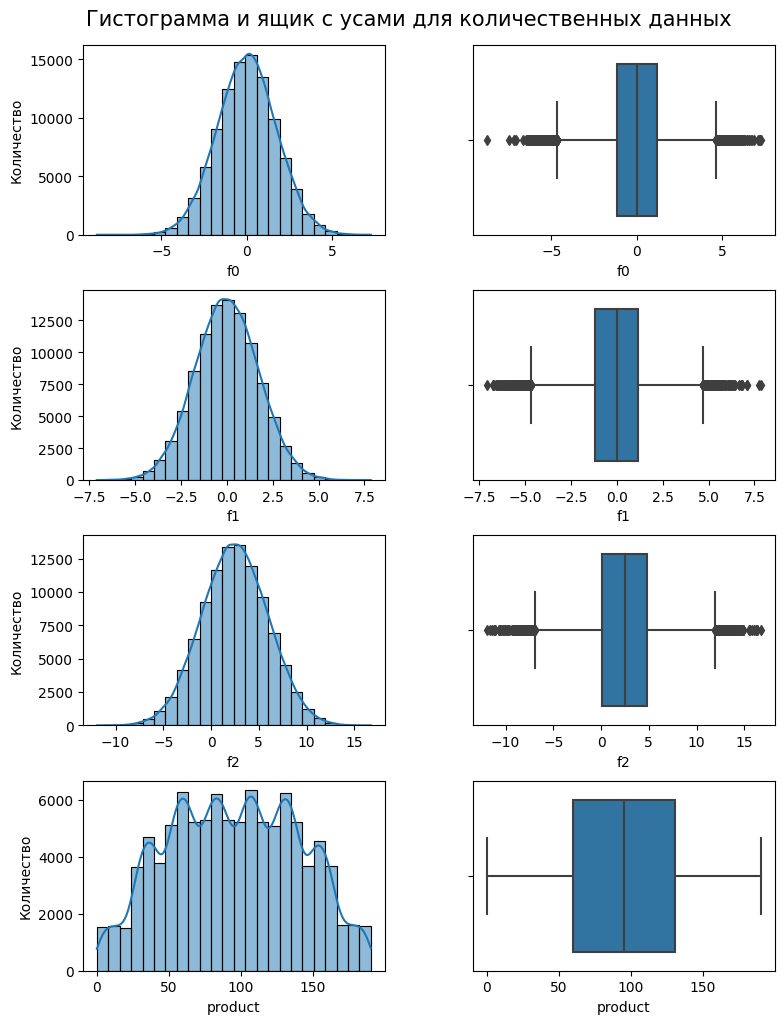

In [15]:
# графическое представление данных из таблицы df_2
plot_hist(df_2,df_2.columns)

**Вывод**
 - пропуски и дубликаты отсутствуют 
 - есть нулевые значения  в столбце product (8235 строк в втором регионе(df_1) (скважины не принесли нефть, или добыча там не осуществляется)
 - в первом и третьем регионе(df_0, df_2) распределение близко к нормальному
 - удален столбцец с id

## Обучение и проверка модели

План действий:
1. Деление данных на обучающую(75%) и валиадационную выборку (25%)
2. Обучение модели и  предсказания на валидационной выборке
3. Сохрание предсказаний и правильные ответы на валидационной выборке.
4. Расчет среднего запаса предсказанного сырья и RMSE модели.


In [17]:
# функция на деление: на вход- данные, на выходе- обучающие(75%) и валидационные воборки(25%) 
def split (df):
 
    features = df.drop("product", axis=1)
    target = df["product"]
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [18]:
#проверка
print("Первый регион-df_0")
features_train_0, features_valid_0, target_train_0, target_valid_0 = split(df_0)
print(features_train_0.shape)
print(features_valid_0.shape)
print(target_train_0.shape)
print(target_valid_0.shape)

print("Второй регион-df_1")
features_train_1, features_valid_1, target_train_1, target_valid_1 = split(df_1)
print(features_train_1.shape)
print(features_valid_1.shape)
print(target_train_1.shape)
print(target_valid_1.shape)

print("Третий  регион-df_2")
features_train_2, features_valid_2, target_train_2, target_valid_2 = split(df_2)
print(features_train_2.shape)
print(features_valid_2.shape)
print(target_train_2.shape)
print(target_valid_2.shape)

Первый регион-df_0
(75000, 3)
(25000, 3)
(75000,)
(25000,)
Второй регион-df_1
(75000, 3)
(25000, 3)
(75000,)
(25000,)
Третий  регион-df_2
(75000, 3)
(25000, 3)
(75000,)
(25000,)


Деление на выборки происходит корректно, из распределения 75%/25%. Далее сформируем общую функцию (для сокращения кода и более удобного восприятия), где поэтапно будет рассписано: деление на выборки, маштабирование, обучение модели Линейная регрессия, расчет 

In [19]:
# функция деления и обучения: на вход - таблица с данными, выход- таблица с predict&fact, rmse, r2
def calculated (df):
 
    features = df.drop('product', axis=1)
    target = df['product']
    #деление на выборки: обуч(75%) и валидац(25%)
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=12345)
    # маштабирование и обучение модели линейной регресии
    pipeline = make_pipeline(StandardScaler(),LinearRegression())
    #отработка модели
    pipeline.fit(features_train, target_train)
    #предсказания модели
    predict = pipeline.predict(features_valid) 
    # предсказания и правильные ответы на валидационной выборке
    total_df = pd.DataFrame({'prediction': predict, 'fact': target_valid}).reset_index(drop=True)
    #корень среднекв. ошибки
    rmse = mean_squared_error(target_valid, predict) ** 0.5
    #коэффициент детерминации
    r2 = r2_score(target_valid, predict)
    return total_df, rmse, r2
    

In [20]:
# вывод таблицы с predict&fact, rmse, r2 по всем регионам
total_df_0, rmse_0, r2_0 = calculated(df_0)
total_df_1, rmse_1, r2_1 = calculated(df_1)
total_df_2, rmse_2, r2_2 = calculated(df_2)

In [21]:
#проверка
print(total_df_0)

       prediction        fact
0       95.894952   10.038645
1       77.572583  114.551489
2       77.892640  132.603635
3       90.175134  169.072125
4       70.510088  122.325180
...           ...         ...
24995  103.037104  170.116726
24996   85.403255   93.632175
24997   61.509833  127.352259
24998  118.180397   99.782700
24999  118.169392  177.821022

[25000 rows x 2 columns]


In [22]:
#оформление итогов в виде таблицы
df_predict = {'Reg_0':[total_df_0["prediction"].mean(), rmse_0, r2_0],
        'Reg_1':[total_df_1["prediction"].mean(), rmse_1, r2_1],
        'Reg_2':[total_df_2["prediction"].mean(), rmse_2, r2_2]}

pd.set_option('display.float_format', '{:.2f}'.format)
table_predict = pd.DataFrame(df_predict)

table_predict.index = ['Средний предсказанный запас сырья', 'RMSE модели', "R2 модели"]

display(table_predict)

,Reg_0,Reg_1,Reg_2
Средний предсказанный запас сырья,92.59,68.73,94.97
RMSE модели,37.58,0.89,40.03
R2 модели,0.28,1.00,0.21


**Вывод:**
- Стоит обратить внимание на Регион_1 и Регион_3. Запасы по ним значительно превышают запасы по региону_2 и составляют примерно 93 и 95тыс баррелей. 
- Значение RMSE ниже во втором регионе, т.е модель ошибается меньше ( в среднем на 0,89 тыс баррелей), в других регионах ошибка составляет от 37 тыс баррелей.
- Смущает значение R2 равный 1 во втором регионе(R2=1 только в одном случае,если MSE нулевое, такая модель предсказывает все ответы идеально, а идеального ничего не бывает). Данные во втором регионе неустойчивые, распределение не носит нормальных характер, с большим количеством строк со значением 0 в столбце product - в связи с чем, надежнее ориентироваться на первый и третий регионы




## Подготовка к расчёту прибыли

План действий:
1. Сохранение ключевых значений в отдельные переменные
2. Расчет достаточного объема сырья для безубыточной разработки новой скважины. Сравнение со средним запасом в каждом регионе


In [23]:
#Основные переменные
ALL_STATION = 500 #общее количество скважин
BEST_STATION = 200 # необходимое количество скважин
BUDGET = 10000 # общий бюджет, млн руб
INCOME = 0.45 #доход с 1 тыс баррелей, млн руб
RISK = 2.5 


<div class="alert alert-block alert-info">
    
<b>Совет:</b> Константы принято записывать в ВЕРХНЕМ РЕГИСТРЕ =) Читем здесь https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#section-29
    

In [25]:
# Расчет точки безубыточности(т.е какой объем должна приносить каждая скважина, чтобы окупить затраты(бюджет) и выйти в ноль)
break_even_point = BUDGET / BEST_STATION / INCOME
print('Min объем каждой скважины для закрытия расходов:',round(break_even_point,2))


Min объем каждой скважины для закрытия расходов: 111.11


In [26]:
for i, name in enumerate([total_df_0,total_df_1,total_df_2]):
    if name["prediction"].mean() > break_even_point:
        print(f'Запасы региона {i}: {round(name["prediction"].mean(),2)} регион доходный')
    else: 
        print (f'Запасы региона {i}: {round(name["prediction"].mean(),2)},что ниже min обьема {round(break_even_point,2)}, регион убыточен')

Запасы региона 0: 92.59,что ниже min обьема 111.11, регион убыточен
Запасы региона 1: 68.73,что ниже min обьема 111.11, регион убыточен
Запасы региона 2: 94.97,что ниже min обьема 111.11, регион убыточен


**Вывод:**

Минимальный обьем одной скважины 111,11 тыс баррелей, для "перекрытия" расходов.

Средний запас регионов составляет:
- reg_0: 92.59,
- reg_1: 68.73
- reg_2: 94.97
 что показывает, что все регионы убыточны.
 
 Это средние значения, которые учитывают скважины с низким объемом и высоким. Подберем 200 скважин с науилучшими показателями
 

<div class="alert alert-block alert-success">
<b>Успех:</b> Значение для безубыточной разработки посчитано верно, с выводом согласен  
</div>


## Расчёт прибыли и рисков 


План действий:

- Функция для расчёта суммарной прибыли по выбранным скважинам(200 скважин с мах значением) и предсказаниям модели:
- Расчет рисков и прибыли для каждого региона с использованием техники Bootstrap с 1000 выборок
- Опредение  средней прибыли, 95%-й доверительного интервала и риска убытков. Убыток — это отрицательная прибыль.


In [27]:
# функция расчета прибыли (на вход: данные с target & predict валидац выборки, 
#на выход - суммарная прибыль с 200 наиболее прибыльных скважин каждого региона, млн.руб)
def revenue (data):
    top_stations = data.sort_values(by = 'prediction', ascending=False)[:BEST_STATION]
    return  round(top_stations['fact'].sum() * INCOME - BUDGET,2)


<div class="alert alert-block alert-success">
<b>Успех:</b> Ф-ция для подсчета прибыли определена верно
</div>

In [28]:
#расчет прибыли с 200 наиболее прибыльных скважин каждого региона
for i, name in enumerate([total_df_0,total_df_1,total_df_2]):
    print(f'Max прибыль c 200 скважин региона {i} составляет {revenue(name)}')
    

Max прибыль c 200 скважин региона 0 составляет 3320.83
Max прибыль c 200 скважин региона 1 составляет 2415.09
Max прибыль c 200 скважин региона 2 составляет 2710.35


In [29]:
# функция для расчета c использованием техники Bootstrap 
# на вход данные с target & predict валидац выборки, номер региона
def distrubtion (data_pred_fact, number):
    state = np.random.RandomState(12345)
    values = []# список со значением прибыли по каждой случ выборке

    for i in range (1000):
        #формирование случайной выборки с количеством строк n(500 скажин для исследования)
        subsample = data_pred_fact.sample(n=ALL_STATION, replace=True, random_state=state)
        values.append(revenue (subsample))
    values = pd.Series(values) #преоброзование списка в Series
    #риски
    negative_profit = (values < 0).mean()
    #средний доход
    mean_profit = round(values.mean(),2)
    #расчет доверительного интервала
    lower = round(values.quantile(0.025),2)
    upper = round(values.quantile(0.975),2)
    sns.histplot(data = values, kde=True)
    plt.axvline(values.mean(), color = 'r', linestyle = '--')
    plt.title(f'Распределение прибыли региона {number}')
    plt.xlabel ('Прибыль')
    plt.show()
    print(f'Средняя прибыль в регионе {number}: {mean_profit} млн.руб')
    print(f'95% доверительный интервал от {lower} до {upper} млн.руб')
    print('Риск убытков: {:.1%}'.format(negative_profit))
    
    return lower, upper, mean_profit, negative_profit

Регион_0


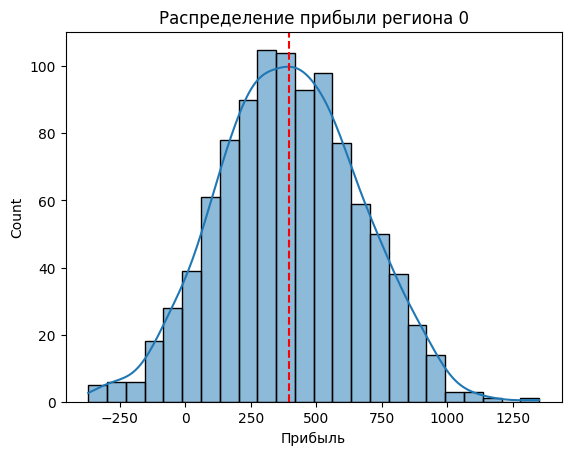

Средняя прибыль в регионе 0: 396.17 млн.руб
95% доверительный интервал от -111.21 до 909.76 млн.руб
Риск убытков: 6.9%


In [30]:
#результаты для первого региона (df_0)
print("Регион_0")
lower_0, upper_0, mean_profit_0, negative_profit_0 = distrubtion (total_df_0, 0)

Регион_1


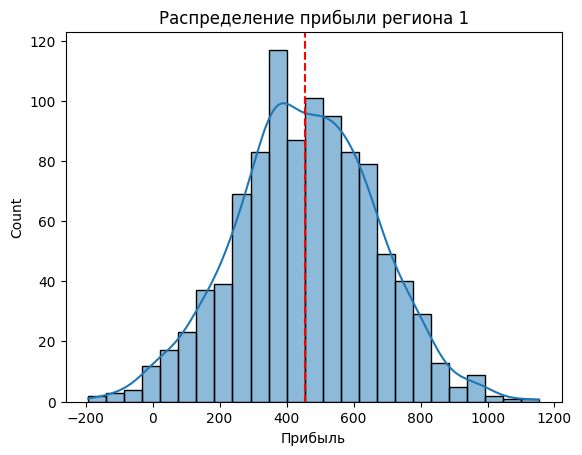

Средняя прибыль в регионе 1: 456.05 млн.руб
95% доверительный интервал от 33.82 до 852.29 млн.руб
Риск убытков: 1.5%


In [31]:
#результаты для второго региона (df_2)
print("Регион_1")
lower_1, upper_1, mean_profit_1, negative_profit_1 = distrubtion (total_df_1, 1)


Регион_2


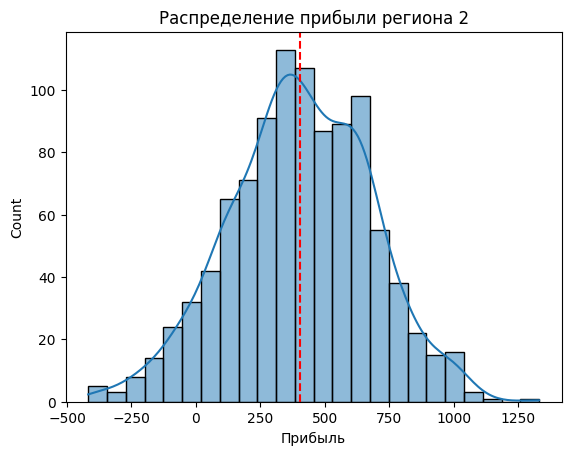

Средняя прибыль в регионе 2: 404.4 млн.руб
95% доверительный интервал от -163.35 до 950.36 млн.руб
Риск убытков: 7.6%


In [32]:
#результаты для третьего региона (df_2)
print("Регион_2")
lower_2, upper_2, mean_profit_2, negative_profit_2 = distrubtion (total_df_2, 2)

In [33]:
#оформление итогов в виде таблицы
df_total_variable = {'Reg_0':[mean_profit_0, lower_0, upper_0, negative_profit_0*100],
        'Reg_1':[mean_profit_1, lower_1, upper_1, negative_profit_1*100],
        'Reg_2':[mean_profit_2, lower_2, upper_2, negative_profit_2*100]}

#pd.set_option('display.float_format', '{:.2f}'.format)
table__total_variable = pd.DataFrame(df_total_variable)

table__total_variable.index = ['Средняя прибыль в регионе, млн.руб', 'Min значение 95% доверительного интервала, млн.руб ',
                               'Max значение 95% доверительного интервала, млн.руб' ,'Риск убытков, %']

display(table__total_variable)

,Reg_0,Reg_1,Reg_2
"Средняя прибыль в регионе, млн.руб",396.17,456.05,404.40
"Min значение 95% доверительного интервала, млн.руб",-111.21,33.82,-163.35
"Max значение 95% доверительного интервала, млн.руб",909.76,852.29,950.36
"Риск убытков, %",6.90,1.50,7.60


**Вывод:**
Наилучшие результаты показал 2 регион(df_1), риск убытков минимальный(1.5%), что соответствует условиям задания (<2.5%) и средняя прибыль выше,чем тот же показатель других регионов.
Для дальнейшей разработки нефтяных скважин стоит рассматривать второй регион.


## Общий вывод:
**На этапе предобработки данных выявлено:**
 - пропуски и дубликаты отсутствуют
 - есть нулевые значения в столбце product (8235 строк в втором регионе(df_1)
 - в первом и третьем регионе(df_0, df_2) распределение близко к нормальному
 
**На этапе обучения и проверки модели:**

 - данные разделены на обучающую(75%) и валиадационную выборку (25%)
 - сохранены предсказания и правильные ответы на валидационной выборке
 - расчитан RMSE. Лучший показатель во втором регионе(df_1), где RMSE = 0.89 (т.е в среднем модель ошибается на 0,89 тыс баррелей).RMSE первого региона(df_0)= 37.58, RMSE третьего региона(df_2)= 40.03
 - показатель R2 во втором регионе(df_1)выше других регионов (R2 = 1), т.е моедль предсказывает идеально, что в целом наводит на ряд вопросов


**На этапе расчёта прибыли и рисков:**
 - сформирована функция для расчёта суммарной прибыли по выбранным скважинам (200 скважин с мах значением) 
 - расчитаны риски и прибыли для каждого региона с использованием техники Bootstrap с 1000 выборок
 - Наилучшие результаты показал 2 регион(df_1), риск убытков минимальный(1.5%), что соответствует условиям задания (<2.5%) и средняя прибыль выше,чем тот же показатель других регионов. Для дальнейшей разработки нефтяных скважин стоит рассматривать второй регион.

